Los datos  se encuentran en la máquina virtual:

`/home/dsc/Data/challenge`:
- `bookings.csv.bz2`
- `searches.csv.bz2`

In [1]:
compartido_VM = "C:/Users/turge/CompartidoVM/Clases 12-13_DS Challenge"
compartido_windows = "C:/Users/turge/CompartidoVM/Python_HostMachine_Windows"

bookings_path = compartido_VM + "/bookings.csv.bz2"
searches_path = compartido_VM + "/searches.csv.bz2"

bookings_nodup_path = compartido_windows + "/bookings.nodup.csv.bz2"
searches_nodup_path = compartido_windows + "/searches.nodup.csv.bz2"

In [2]:
import bz2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

## Exercise 1

#### Count the number of lines in Python for each file

In [3]:
fileBz2 = bz2.BZ2File(bookings_path)

In [4]:
type(fileBz2)

bz2.BZ2File

In [11]:
%%time
fileBz2 = bz2.BZ2File(bookings_path)

k = 0
for line in fileBz2:
    k += 1
print(k)

# Resultado: 10000011 filas

10000011
Wall time: 3min 9s


In [5]:
fileBz2.closed

False

In [6]:
fileBz2.close()

In [7]:
fileBz2.closed

True

Para evitar el problema de olvidar cerrar el archivo...

In [17]:
%%time
with bz2.BZ2File(bookings_path) as fileBz2:
    k = 0
    for line in fileBz2:
        k += 1
# Cuando sales del "with" se cierra el archivo, y se previene así el problema del puntero
bookings_path_rows = k
print("'Bookings' file has {} rows.".format(k))
# Resultado: 10000011 filas

'Bookings' file has 10000011 rows.
Wall time: 3min 7s


In [18]:
%%time
with bz2.BZ2File(searches_path) as fileBz2:
    k = 0
    for line in fileBz2:
        k += 1
# Cuando sales del "with" se cierra el archivo, y se previene así el problema del puntero
searches_path_rows = k
print("'Searches' file has {} rows.".format(k))
# Resultado: 20390199 filas

'Searches' file has 20390199 rows.
Wall time: 3min 38s


In [8]:
# Comprobación de que está cerrado:
fileBz2.closed

True

[Large, persistent DataFrame in pandas](https://stackoverflow.com/questions/11622652/large-persistent-dataframe-in-pandas/12193309#12193309)

In [90]:
%%time
# Eliminar los duplicates del archivo completo y creación del archivo resultante:
tp = pd.read_csv(bookings_path,
                 sep='^', 
                 iterator=True,
                 chunksize=500000,
                 low_memory=False,
                 dtype=str)
all_chunks = pd.DataFrame()

for i, chunk in enumerate(tp):
    print(i, len(all_chunks))
    all_chunks = all_chunks.append(chunk)
    all_chunks.drop_duplicates(inplace=True) # Eliminar todos los duplicados totales

# Aprovechar para limpiar etiquetas de columnas:
all_chunks.columns = all_chunks.columns.str.strip()
all_chunks['dep_port'] = all_chunks['dep_port'].str.strip().str.upper()
all_chunks['arr_port'] = all_chunks['arr_port'].str.strip().str.upper()

all_chunks.to_csv(bookings_nodup_path,
                  sep='^',
                  index=False)

# NOTA: tras cierto número de Chunks, deja de incluir nuevas filas porque son TODOS duplicados

0 0
1 500000
2 1000000
3 1000000
4 1000000
5 1000000
6 1000000
7 1000000
8 1000000
9 1000000
10 1000000
11 1000003
12 1000003
13 1000003
14 1000003
15 1000003
16 1000003
17 1000003
18 1000003
19 1000003
20 1000003
Wall time: 7min 55s


In [91]:
%%time
# Eliminar los duplicates del archivo completo y creación del archivo resultante:
tp = pd.read_csv(searches_path,
                 sep='^', 
                 iterator=True,
                 chunksize=500000,
                 low_memory=False,
                 dtype=str)
all_chunks = pd.DataFrame()

for i, chunk in enumerate(tp):
    print(i, len(all_chunks))
    all_chunks = all_chunks.append(chunk)
    all_chunks.drop_duplicates(inplace=True) # Eliminar todos los duplicados totales

# Aprovechar para limpiar etiquetas de columnas:
all_chunks.columns = all_chunks.columns.str.strip()
all_chunks['Origin'] = all_chunks['Origin'].str.strip().str.upper()
all_chunks['Destination'] = all_chunks['Destination'].str.strip().str.upper()

all_chunks.to_csv(searches_nodup_path,
                  sep='^',
                  index=False)

# NOTA: tras cierto número de Chunks, deja de incluir nuevas filas porque son TODOS duplicados

0 0
1 358999
2 358999
3 359003
4 359003
5 359003
6 359003
7 359003
8 359003
9 359003
10 359003
11 359003
12 359003
13 359003
14 359003
15 359003
16 359003
17 359003
18 359003
19 359003
20 359003
21 359003
22 359003
23 359003
24 359003
25 359003
26 359003
27 359003
28 359003
29 359003
30 359003
31 359003
32 359003
33 359003
34 359003
35 359003
36 359003
37 359003
38 359003
39 359003
40 359003
Wall time: 7min 51s


## Exercise 2

#### Top 10 arrival airports in the world in 2013 (using the bookings file)

- Arrival airport is the column arr_port. It is the IATA code for the airport
- To get the total number of passengers for an airport, you can sum the column pax, grouping by arr_port. Note that there is negative pax. That corresponds to cancelations. So to get the total number of passengers that have actually booked, you should sum including the negatives (that will remove the canceled bookings).
- Print the top 10 arrival airports in the standard output, including the number of passengers.
- **Bonus point**: Get the name of the city or airport corresponding to that airport (programatically, we suggest to have a look at **GeoBases in Github**)
- **Bonus point**: Solve this problem using pandas (instead of any other approach)

In [26]:
%%time

tp = pd.read_csv(bookings_nodup_path,
                 usecols=['arr_port', 'pax'],
                 sep='^',
                 iterator=True,
                 low_memory=False,
                 chunksize=10000)

iter_max = 1e8 # Usar '5' para test

df_all = pd.DataFrame()
for k, chunk in tqdm(enumerate(tp)):
    chunk['arr_port'] = chunk['arr_port'].str.strip().str.upper()
    group_chunk = chunk.groupby('arr_port').sum()
    df_all = df_all.append(group_chunk).sort_values(by='pax', ascending=False)

    if k == iter_max: # Comprobador
        break # Comprobador


group_all = df_all.groupby('arr_port').sum().sort_values(by='pax', ascending=False)
group_all.to_csv('Exercise_2_result_df.csv',
                 sep='^',
                 index=False)

1it [00:00,  2.91it/s]

40 0


2it [00:00,  3.25it/s]

40 663


3it [00:00,  3.50it/s]

40 1342


4it [00:01,  3.74it/s]

40 2026


5it [00:01,  3.81it/s]

40 2781


6it [00:01,  4.00it/s]

40 3451


7it [00:01,  4.12it/s]

40 4188


8it [00:01,  4.25it/s]

40 4893


9it [00:02,  4.11it/s]

40 5607
40

10it [00:02,  4.32it/s]

 6322


11it [00:02,  4.32it/s]

40 7039


12it [00:02,  4.30it/s]

40 7769


13it [00:03,  4.35it/s]

40 8497


14it [00:03,  4.39it/s]

40 9225


15it [00:03,  4.50it/s]

40 9942


16it [00:03,  4.41it/s]

40 10657


17it [00:03,  4.40it/s]

40 11370


18it [00:04,  4.29it/s]

40 12081


19it [00:04,  4.37it/s]

40 12790


20it [00:04,  4.34it/s]

40 13481


21it [00:04,  4.44it/s]

40 14209


22it [00:05,  4.28it/s]

40 14914


23it [00:05,  4.38it/s]

40 15630


24it [00:05,  4.51it/s]

40 16333


25it [00:05,  4.42it/s]

40 17041


26it [00:06,  4.33it/s]

40 17747
40 18480


28it [00:06,  4.47it/s]

40 19194


29it [00:06,  4.40it/s]

40 19906


30it [00:06,  4.40it/s]

40 20618


31it [00:07,  4.33it/s]

40 21318


32it [00:07,  4.26it/s]

40 22050
40 22768


34it [00:07,  4.26it/s]

40 23481


35it [00:08,  4.19it/s]

40 24215


36it [00:08,  4.30it/s]

40 24908


37it [00:08,  4.32it/s]

40 25622


38it [00:08,  4.25it/s]

40 26332


39it [00:09,  4.29it/s]

40 27045


40it [00:09,  4.32it/s]

40 27763


41it [00:09,  4.34it/s]

40 28477


42it [00:09,  4.37it/s]

40 29178


43it [00:09,  4.34it/s]

40 29906


44it [00:10,  4.38it/s]

40 30650


45it [00:10,  4.28it/s]

40 31406


46it [00:10,  4.32it/s]

40 32127


47it [00:10,  4.29it/s]

40 32855


48it [00:11,  4.22it/s]

40 33584


49it [00:11,  4.26it/s]

40 34297


50it [00:11,  4.37it/s]

40 35013


51it [00:11,  4.25it/s]

40 35728


52it [00:12,  4.03it/s]

40 36462


53it [00:12,  3.76it/s]

40 37194


54it [00:12,  3.65it/s]

40 37923


55it [00:12,  3.85it/s]

40 38655


56it [00:13,  3.99it/s]

40 39394


57it [00:13,  4.04it/s]

40 40120


58it [00:13,  4.13it/s]

40 40861


59it [00:13,  4.08it/s]

40 41620


60it [00:14,  4.09it/s]

40 42338


61it [00:14,  4.19it/s]

40 43051
40

62it [00:14,  4.32it/s]

 43770


63it [00:14,  4.29it/s]

40 44468


64it [00:15,  4.27it/s]

40 45198
40 45943


66it [00:15,  4.35it/s]

40 46664


67it [00:15,  4.30it/s]

40 47390


68it [00:16,  4.24it/s]

40 48149


69it [00:16,  4.33it/s]

40 48896


70it [00:16,  4.12it/s]

40 49642


71it [00:16,  4.22it/s]

40 50393


72it [00:16,  4.27it/s]

40 51122


73it [00:17,  4.16it/s]

40 51851


74it [00:17,  4.30it/s]

40 52602


75it [00:17,  4.25it/s]

40 53340


76it [00:17,  4.24it/s]

40 54078


77it [00:18,  4.26it/s]

40 54800


78it [00:18,  4.18it/s]

40 55551


79it [00:18,  4.16it/s]

40 56282


80it [00:18,  4.27it/s]

40 57007


81it [00:19,  4.18it/s]

40 57741


82it [00:19,  4.21it/s]

40 58451


83it [00:19,  4.29it/s]

40 59158


84it [00:19,  4.25it/s]

40 59901


85it [00:20,  4.19it/s]

40 60639


86it [00:20,  4.25it/s]

40 61367


87it [00:20,  4.30it/s]

40 62099


88it [00:20,  4.14it/s]

40 62814


89it [00:20,  4.23it/s]

40 63524


90it [00:21,  4.19it/s]

40 64264


91it [00:21,  4.22it/s]

40 65017


92it [00:21,  4.20it/s]

40 65753


93it [00:21,  4.16it/s]

40 66487


94it [00:22,  4.06it/s]

40 67244


95it [00:22,  4.15it/s]

40 67983


96it [00:22,  4.13it/s]

40 68727


97it [00:22,  4.09it/s]

40 69424


98it [00:23,  4.09it/s]

40 70147


99it [00:23,  4.15it/s]

40 70874


100it [00:23,  4.24it/s]

40 71605


101it [00:23,  4.14it/s]

40 72363


102it [00:24,  4.12it/s]

40 73027


103it [00:24,  4.13it/s]

40 73706


104it [00:24,  4.15it/s]

40 74390


105it [00:24,  4.10it/s]

40 75145


106it [00:25,  4.17it/s]

40 75815


107it [00:25,  4.10it/s]

40 76552


108it [00:25,  4.12it/s]

40 77256


109it [00:25,  4.11it/s]

40 77970


110it [00:26,  4.07it/s]

40 78685


111it [00:26,  4.07it/s]

40 79402


112it [00:26,  4.13it/s]

40 80133


113it [00:26,  4.03it/s]

40 80861


114it [00:27,  4.01it/s]

40 81589


115it [00:27,  4.15it/s]

40 82306


116it [00:27,  4.15it/s]

40 83022


117it [00:27,  4.09it/s]

40 83735


118it [00:28,  4.17it/s]

40 84446


119it [00:28,  4.09it/s]

40 85155


120it [00:28,  4.04it/s]

40 85846


121it [00:28,  4.09it/s]

40 86574


122it [00:28,  4.13it/s]

40 87279


123it [00:29,  4.02it/s]

40 87995


124it [00:29,  4.15it/s]

40 88698


125it [00:29,  4.06it/s]

40 89405


126it [00:29,  4.06it/s]

40 90112


127it [00:30,  4.05it/s]

40 90845


128it [00:30,  4.02it/s]

40 91559


129it [00:30,  3.95it/s]

40 92271


130it [00:30,  4.07it/s]

40 92983


131it [00:31,  4.05it/s]

40 93683


132it [00:31,  4.07it/s]

40 94415


133it [00:31,  4.03it/s]

40 95133


134it [00:31,  4.08it/s]

40 95845


135it [00:32,  4.06it/s]

40 96580


136it [00:32,  4.06it/s]

40 97273


137it [00:32,  3.99it/s]

40 97987


138it [00:32,  3.96it/s]

40 98697


139it [00:33,  4.02it/s]

40 99411


140it [00:33,  4.03it/s]

40 100128


141it [00:33,  3.98it/s]

40 100843


142it [00:33,  4.00it/s]

40 101544


143it [00:34,  3.98it/s]

40 102272


144it [00:34,  4.05it/s]

40 103016


145it [00:34,  3.96it/s]

40 103772


146it [00:34,  3.99it/s]

40 104493


147it [00:35,  3.88it/s]

40 105221


148it [00:35,  4.04it/s]

40 105950


149it [00:35,  3.96it/s]

40 106663


150it [00:35,  4.17it/s]

40 107379
Wall time: 36.2 s


In [27]:
group_all

,pax
arr_port,
LHR,13560.0
MCO,10992.0
LAX,10695.0
LAS,10367.0
JFK,10115.0
...,...
SDJ,-11.0
MYJ,-16.0
SCQ,-23.0


In [5]:
%%time

tp = pd.read_csv(bookings_path,
                 usecols=['arr_port', 'pax'],
                 sep='^',
                 iterator=True,
                 low_memory=False,
                 chunksize=10000)

iter_max = 1e8 # Usar '5' para test

df_all = pd.DataFrame()
for k, chunk in tqdm(enumerate(tp)):
    chunk['arr_port'] = chunk['arr_port'].str.strip().str.upper()
    group_chunk = chunk.groupby('arr_port').sum()
    df_all = df_all.append(group_chunk).sort_values(by='pax', ascending=False)

    if k == iter_max: # Comprobador
        break # Comprobador


group_all = df_all.groupby('arr_port').sum().sort_values(by='pax', ascending=False)
group_all.to_csv('Exercise_2_result_df_withdup.csv',
                 sep='^',
                 index=True)

1001it [05:41,  2.93it/s]


Wall time: 5min 41s


In [4]:
group_all

,pax
arr_port,
LHR,88809.0
MCO,70930.0
LAX,70530.0
LAS,69630.0
JFK,66270.0
...,...
MYJ,-80.0
UPG,-90.0
XWG,-90.0


## Exercise 3

#### Plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona

- For the arriving airport, you can use the Destination column in the searches file.
- Plot a curve for Málaga, another one for Madrid, and another one for Barcelona, in the same figure.
- **Bonus point**: Solving this problem using pandas (instead of any other approach)

In [33]:
%%time

# Importa el archivo, troceándolo en chunks (20390199 filas):
tp = pd.read_csv(searches_nodup_path,
                 sep='^',
                 usecols=['Date','Destination'], 
                 iterator=True,
                 chunksize=500000)

# TEST: número de iteraciones máximas para testeo
iter_max = 1e8
# Crear un DataFrame vacío para appendear cada resultado de los chunks:
df4 = pd.DataFrame()

# Iterar por cada chunk:
for k, chunk in tqdm(enumerate(tp)):
    # TEST: al llegar al número máximo de iteraciones permitido, interrumpe el proceso:
    if k == iter_max: # Comprobador
        break # Comprobador
    # Crear columnas auxiliares de Año y Mes:
    chunk['year'] = chunk['Date'].str[:4]
    chunk['month'] = chunk['Date'].str[5:7]
    # Listar las ciudades (IATAs) buscadas:
    cities = ['AGP', 'MAD', 'BCN']
    # Filtrar por las ciudades buscadas:
    df2 = chunk[chunk['Destination'].isin(cities)]
    # Agrupar primero por Ciudad, luego por Año, y finalmente por Mes (reset_index para formato por columnas):
    df3 = df2.groupby(['Destination', 'year', 'month']).count().reset_index()
    # Appendear el grupo resultante al DataFrame inicialmente vacío (df4):
    df4 = df4.append(df3)

# Almacenar el df4 resultante:
df4.to_csv('Exercise_3_result_df_withoutdup.csv',
                 sep='^',
                 index=False)

2it [00:07,  3.86s/it]

Wall time: 7.77 s


In [35]:
df4

,Destination,year,month,Date
0,AGP,2013,01,338
1,AGP,2013,02,294
2,AGP,2013,03,212
3,AGP,2013,04,145
4,AGP,2013,05,190
5,AGP,2013,06,139
6,AGP,2013,07,156
7,AGP,2013,08,138
8,AGP,2013,09,143
9,AGP,2013,10,189


<AxesSubplot:xlabel='month', ylabel='Date'>

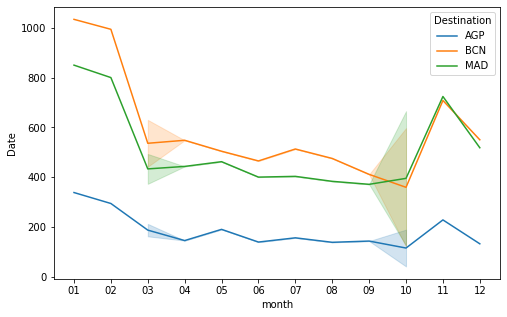

In [36]:
# Plotea el resultado final
fig,ax1 = plt.subplots(figsize=(8,5))
sns.lineplot(data=df4[df4['year'] == '2013'],
            x='month',
            y='Date',
            hue='Destination',
            ax=ax1)

In [143]:
# Repetición, esta vez con el archivo conn duplicados:

In [37]:
%%time

# Importa el archivo, troceándolo en chunks (20390199 filas):
tp = pd.read_csv(searches_path,
                 sep='^',
                 usecols=['Date','Destination'], 
                 iterator=True,
                 chunksize=500000)

# TEST: número de iteraciones máximas para testeo
iter_max = 1e8
# Crear un DataFrame vacío para appendear cada resultado de los chunks:
df4 = pd.DataFrame()

# Iterar por cada chunk:
for k, chunk in tqdm(enumerate(tp)):
    # TEST: al llegar al número máximo de iteraciones permitido, interrumpe el proceso:
    if k == iter_max: # Comprobador
        break # Comprobador
    # Crear columnas auxiliares de Año y Mes:
    chunk['year'] = chunk['Date'].str[:4]
    chunk['month'] = chunk['Date'].str[5:7]
    # Listar las ciudades (IATAs) buscadas:
    cities = ['AGP', 'MAD', 'BCN']
    # Filtrar por las ciudades buscadas:
    df2 = chunk[chunk['Destination'].isin(cities)]
    # Agrupar primero por Ciudad, luego por Año, y finalmente por Mes (reset_index para formato por columnas):
    df3 = df2.groupby(['Destination', 'year', 'month']).count().reset_index()
    # Appendear el grupo resultante al DataFrame inicialmente vacío (df4):
    df4 = df4.append(df3)

# Almacenar el df4 resultante:
df4.to_csv('Exercise_3_result_df_withdup.csv',
                 sep='^',
                 index=False)

41it [03:47,  5.54s/it]

Wall time: 3min 47s


In [38]:
df4

,Destination,year,month,Date
0,AGP,2013,01,338
1,AGP,2013,02,294
2,AGP,2013,03,374
3,AGP,2013,04,290
4,AGP,2013,05,310
...,...,...,...,...
31,MAD,2013,08,383
32,MAD,2013,09,594
33,MAD,2013,10,569
34,MAD,2013,11,362


<AxesSubplot:xlabel='month', ylabel='Date'>

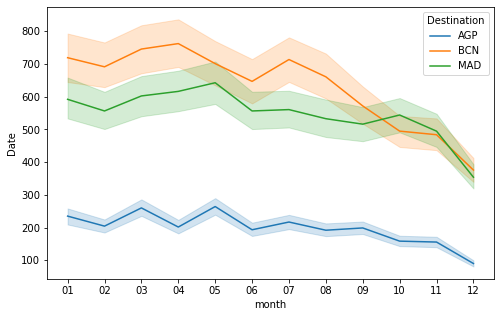

In [39]:
# Plotea el resultado final
fig,ax1 = plt.subplots(figsize=(8,5))
sns.lineplot(data=df4[df4['year'] == '2013'],
            x='month',
            y='Date',
            hue='Destination',
            ax=ax1)

## Exercise 4

#### Match searches with bookings

- For every search in the searches file, find out whether the search ended up in a booking or not (using the info in the bookings file). For instance, search and booking origin and destination should match.
- For the bookings file, origin and destination are the columns dep_port and arr_port, respectively.
- Generate a CSV file with the search data, and an additional field, containing 1 if the search ended up in a booking, and 0 otherwise.

In [9]:
pd.set_option('display.max_columns', None)

In [92]:
%%time

# SAMPLE !!!

# Importa los archivos, troceándolos en chunks:
tp_searches_all = pd.read_csv(searches_nodup_path,
                 sep='^',
                 nrows=100000,
                 iterator=True,
                 chunksize=500000)

tp_bookings_all = pd.read_csv(bookings_nodup_path,
                 sep='^',
                 nrows=100000,
                 iterator=True,
                 chunksize=500000)

# TEST: número de iteraciones máximas para testeo
iter_max = 5
# Crear DataFrames vacíos para appendear cada resultado de los chunks:
df_s_all = pd.DataFrame()
df_b_all = pd.DataFrame()

# Iterar por cada chunk:
for k, chunk in tqdm(enumerate(tp_searches_all)):
    # TEST: al llegar al número máximo de iteraciones permitido, interrumpe el proceso:
    if k == iter_max: # Comprobador
        break # Comprobador
    df_s_all = df_s_all.append(chunk)
    
for k, chunk in tqdm(enumerate(tp_bookings_all)):
    # TEST: al llegar al número máximo de iteraciones permitido, interrumpe el proceso:
    if k == iter_max: # Comprobador
        break # Comprobador
    df_b_all = df_b_all.append(chunk)

1it [00:01,  1.72s/it]
1it [00:02,  2.43s/it]

Wall time: 4.24 s


In [93]:
df_s_all['itinerary'] = df_s_all['Origin'].str[:] + "-" + df_s_all['Destination'].str[:]
df_s_all

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,itinerary
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA,TXL-AUH
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV,ATH-MIL
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC,ICT-SFO
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO,RNB-ARN
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL,OSL-MAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2013-04-10,12:51:24,MPT,533d88ecea8b7fb3425bdf1246cb3763,IN,DEL,TRV,1,2,DEL,TRV,2013-04-13,NaN,NaN,TRV,DEL,2013-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,DEL,DEL-TRV
99996,2013-04-10,11:18:09,MPT,19901d49edef6724c65e38ee8d5957b7,US,BUF,AUA,1,2,BUF,AUA,2013-06-08,NaN,NaN,AUA,BUF,2013-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC,BUF-AUA
99997,2013-04-10,20:40:47,MPT,8b4fa4e121637f583bfa86ef0fa26c9e,US,JFK,KUL,1,2,JFK,KUL,2013-05-02,NaN,NaN,KUL,JFK,2013-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,LAS,JFK-KUL
99998,2013-04-10,05:39:16,MPT,8b4fa4e121637f583bfa86ef0fa26c9e,US,STL,SEA,0,1,STL,SEA,2013-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,LAS,STL-SEA


In [94]:
df_s_all_cols = df_s_all.columns
df_s_all_cols

Index(['Date', 'Time', 'TxnCode', 'OfficeID', 'Country', 'Origin',
       'Destination', 'RoundTrip', 'NbSegments', 'Seg1Departure',
       'Seg1Arrival', 'Seg1Date', 'Seg1Carrier', 'Seg1BookingCode',
       'Seg2Departure', 'Seg2Arrival', 'Seg2Date', 'Seg2Carrier',
       'Seg2BookingCode', 'Seg3Departure', 'Seg3Arrival', 'Seg3Date',
       'Seg3Carrier', 'Seg3BookingCode', 'Seg4Departure', 'Seg4Arrival',
       'Seg4Date', 'Seg4Carrier', 'Seg4BookingCode', 'Seg5Departure',
       'Seg5Arrival', 'Seg5Date', 'Seg5Carrier', 'Seg5BookingCode',
       'Seg6Departure', 'Seg6Arrival', 'Seg6Date', 'Seg6Carrier',
       'Seg6BookingCode', 'From', 'IsPublishedForNeg', 'IsFromInternet',
       'IsFromVista', 'TerminalID', 'InternetOffice', 'itinerary'],
      dtype='object')

In [95]:
df_b_all['itinerary'] = df_b_all['dep_port'].str[:] + "-" + df_b_all['arr_port'].str[:]
df_b_all

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid,itinerary
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHRZRH,LONZRH,CHGB,1,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NULL,ZRH-LHR
1,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,SAL,SAL,SV,CLT,CLT,US,CLTSAL,CLTSAL,SVUS,1,SALATLCLT,NV,L,Y,2013-04-12 13:04:00,2013-04-12 22:05:40,1,2013,3,NULL,SAL-CLT
2,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLTSAL,CLTSAL,SVUS,1,CLTATLSAL,NV,U,Y,2013-07-15 07:00:00,2013-07-15 11:34:51,1,2013,3,NULL,SAL-CLT
3,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKL,AKL,NZ,SVO,MOW,RU,AKLSVO,AKLMOW,NZRU,1,AKLHKGSVO,XK,G,Y,2013-04-24 23:59:00,2013-04-25 16:06:31,1,2013,3,SYDA82546,AKL-SVO
4,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKLSVO,AKLMOW,NZRU,1,SVOHKGAKL,XK,G,Y,2013-05-14 20:15:00,2013-05-16 10:44:50,1,2013,3,SYDA82546,AKL-SVO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2013-03-03 00:00:00,1G,FR,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,2013-02-28 00:00:00,11731,0,DEL,DEL,IN,IXL,IXL,IN,DEL,DEL,IN,DEL,DEL,IN,IXL,IXL,IN,DELIXL,DELIXL,ININ,0,DELIXL,CH,N,Y,2013-05-02 05:40:00,2013-05-02 07:11:47,2,2013,3,NULL,DEL-IXL
99996,2013-03-05 00:00:00,1G,FR,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,2013-02-28 00:00:00,11731,0,DEL,DEL,IN,IXL,IXL,IN,DEL,DEL,IN,DEL,DEL,IN,IXL,IXL,IN,DELIXL,DELIXL,ININ,0,DELIXL,CH,N,Y,2013-05-02 05:40:00,2013-05-02 07:11:47,-2,2013,3,NULL,DEL-IXL
99997,2013-03-05 00:00:00,1G,FR,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,2013-02-28 00:00:00,11731,0,DEL,DEL,IN,IXL,IXL,IN,DEL,DEL,IN,IXL,IXL,IN,DEL,DEL,IN,DELIXL,DELIXL,ININ,0,IXLDEL,CH,Q,Y,2013-05-10 07:40:00,2013-05-10 09:11:47,-2,2013,3,NULL,DEL-IXL
99998,2013-03-20 00:00:00,1G,ZA,355368d5d743bd879313059478579059,a6dc7522954b518c8530ee2058ac946a,34ce3041cf21fe149b175c82dc991183,2013-03-20 00:00:00,4612,0,HLA,JNB,ZA,CPT,CPT,ZA,HLA,JNB,ZA,HLA,JNB,ZA,CPT,CPT,ZA,CPTHLA,CPTJNB,ZAZA,0,HLACPT,WX,O,Y,2013-06-14 14:55:00,2013-06-14 17:12:14,2,2013,3,NULL,HLA-CPT


In [96]:
df_b_all_cols = df_b_all.columns
df_b_all_cols

Index(['act_date', 'source', 'pos_ctry', 'pos_iata', 'pos_oid', 'rloc',
       'cre_date', 'duration', 'distance', 'dep_port', 'dep_city', 'dep_ctry',
       'arr_port', 'arr_city', 'arr_ctry', 'lst_port', 'lst_city', 'lst_ctry',
       'brd_port', 'brd_city', 'brd_ctry', 'off_port', 'off_city', 'off_ctry',
       'mkt_port', 'mkt_city', 'mkt_ctry', 'intl', 'route', 'carrier',
       'bkg_class', 'cab_class', 'brd_time', 'off_time', 'pax', 'year',
       'month', 'oid', 'itinerary'],
      dtype='object')

In [97]:
df_s_all.head(5)

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,itinerary
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA,TXL-AUH
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV,ATH-MIL
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC,ICT-SFO
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO,RNB-ARN
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL,OSL-MAD


In [98]:
df_b_all.head(5)

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid,itinerary
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHRZRH,LONZRH,CHGB,1,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NULL,ZRH-LHR
1,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,SAL,SAL,SV,CLT,CLT,US,CLTSAL,CLTSAL,SVUS,1,SALATLCLT,NV,L,Y,2013-04-12 13:04:00,2013-04-12 22:05:40,1,2013,3,NULL,SAL-CLT
2,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLTSAL,CLTSAL,SVUS,1,CLTATLSAL,NV,U,Y,2013-07-15 07:00:00,2013-07-15 11:34:51,1,2013,3,NULL,SAL-CLT
3,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKL,AKL,NZ,SVO,MOW,RU,AKLSVO,AKLMOW,NZRU,1,AKLHKGSVO,XK,G,Y,2013-04-24 23:59:00,2013-04-25 16:06:31,1,2013,3,SYDA82546,AKL-SVO
4,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKLSVO,AKLMOW,NZRU,1,SVOHKGAKL,XK,G,Y,2013-05-14 20:15:00,2013-05-16 10:44:50,1,2013,3,SYDA82546,AKL-SVO


In [99]:
%%time

# SAMPLE !!!

# Importa los archivos, troceándolos en chunks:
tp_searches = pd.read_csv(searches_nodup_path,
                 sep='^',
                 nrows=100000,
                 usecols=['Date', 'Time', 'Origin', 'Destination', 'OfficeID', 'TerminalID'],
                 iterator=True,
                 chunksize=500000)

tp_bookings = pd.read_csv(bookings_nodup_path,
                 sep='^',
                 nrows=100000,
                 usecols=['act_date', 'dep_port', 'arr_port', 'pax', 'pos_iata', 'pos_oid', 'rloc'],
                 iterator=True,
                 chunksize=500000)

# TEST: número de iteraciones máximas para testeo
iter_max = 5
# Crear DataFrames vacíos para appendear cada resultado de los chunks:
df_s = pd.DataFrame()
df_b = pd.DataFrame()

# Iterar por cada chunk:
for k, chunk in tqdm(enumerate(tp_searches)):
    # TEST: al llegar al número máximo de iteraciones permitido, interrumpe el proceso:
    if k == iter_max: # Comprobador
        break # Comprobador
    df_s = df_s.append(chunk)
    
for k, chunk in tqdm(enumerate(tp_bookings)):
    # TEST: al llegar al número máximo de iteraciones permitido, interrumpe el proceso:
    if k == iter_max: # Comprobador
        break # Comprobador
    df_b = df_b.append(chunk)

1it [00:01,  1.07s/it]
1it [00:01,  1.92s/it]

Wall time: 3.04 s


In [100]:
df_s

,Date,Time,OfficeID,Origin,Destination,TerminalID
0,2013-01-01,20:25:57,624d8c3ac0b3a7ca03e3c167e0f48327,TXL,AUH,d41d8cd98f00b204e9800998ecf8427e
1,2013-01-01,10:15:33,b0af35b31588dc4ab06d5cf2986e8e02,ATH,MIL,d41d8cd98f00b204e9800998ecf8427e
2,2013-01-01,18:04:49,3561a60621de06ab1badc8ca55699ef3,ICT,SFO,d41d8cd98f00b204e9800998ecf8427e
3,2013-01-01,17:42:40,1864e5e8013d9414150e91d26b6a558b,RNB,ARN,d41d8cd98f00b204e9800998ecf8427e
4,2013-01-01,17:48:29,1ec336348f44207d2e0027dc3a68c118,OSL,MAD,d41d8cd98f00b204e9800998ecf8427e
...,...,...,...,...,...,...
99995,2013-04-10,12:51:24,533d88ecea8b7fb3425bdf1246cb3763,DEL,TRV,d41d8cd98f00b204e9800998ecf8427e
99996,2013-04-10,11:18:09,19901d49edef6724c65e38ee8d5957b7,BUF,AUA,d41d8cd98f00b204e9800998ecf8427e
99997,2013-04-10,20:40:47,8b4fa4e121637f583bfa86ef0fa26c9e,JFK,KUL,d41d8cd98f00b204e9800998ecf8427e
99998,2013-04-10,05:39:16,8b4fa4e121637f583bfa86ef0fa26c9e,STL,SEA,d41d8cd98f00b204e9800998ecf8427e


In [101]:
df_s['itinerary'] = df_s['Origin'].str[:] + "-" + df_s['Destination'].str[:]
df_s['key'] = df_s['itinerary'].str[:] + "-" + df_s['OfficeID'].str[:]
df_s

,Date,Time,OfficeID,Origin,Destination,TerminalID,itinerary,key
0,2013-01-01,20:25:57,624d8c3ac0b3a7ca03e3c167e0f48327,TXL,AUH,d41d8cd98f00b204e9800998ecf8427e,TXL-AUH,TXL-AUH-624d8c3ac0b3a7ca03e3c167e0f48327
1,2013-01-01,10:15:33,b0af35b31588dc4ab06d5cf2986e8e02,ATH,MIL,d41d8cd98f00b204e9800998ecf8427e,ATH-MIL,ATH-MIL-b0af35b31588dc4ab06d5cf2986e8e02
2,2013-01-01,18:04:49,3561a60621de06ab1badc8ca55699ef3,ICT,SFO,d41d8cd98f00b204e9800998ecf8427e,ICT-SFO,ICT-SFO-3561a60621de06ab1badc8ca55699ef3
3,2013-01-01,17:42:40,1864e5e8013d9414150e91d26b6a558b,RNB,ARN,d41d8cd98f00b204e9800998ecf8427e,RNB-ARN,RNB-ARN-1864e5e8013d9414150e91d26b6a558b
4,2013-01-01,17:48:29,1ec336348f44207d2e0027dc3a68c118,OSL,MAD,d41d8cd98f00b204e9800998ecf8427e,OSL-MAD,OSL-MAD-1ec336348f44207d2e0027dc3a68c118
...,...,...,...,...,...,...,...,...
99995,2013-04-10,12:51:24,533d88ecea8b7fb3425bdf1246cb3763,DEL,TRV,d41d8cd98f00b204e9800998ecf8427e,DEL-TRV,DEL-TRV-533d88ecea8b7fb3425bdf1246cb3763
99996,2013-04-10,11:18:09,19901d49edef6724c65e38ee8d5957b7,BUF,AUA,d41d8cd98f00b204e9800998ecf8427e,BUF-AUA,BUF-AUA-19901d49edef6724c65e38ee8d5957b7
99997,2013-04-10,20:40:47,8b4fa4e121637f583bfa86ef0fa26c9e,JFK,KUL,d41d8cd98f00b204e9800998ecf8427e,JFK-KUL,JFK-KUL-8b4fa4e121637f583bfa86ef0fa26c9e
99998,2013-04-10,05:39:16,8b4fa4e121637f583bfa86ef0fa26c9e,STL,SEA,d41d8cd98f00b204e9800998ecf8427e,STL-SEA,STL-SEA-8b4fa4e121637f583bfa86ef0fa26c9e


In [102]:
df_s.dtypes

Date           object
Time           object
OfficeID       object
Origin         object
Destination    object
TerminalID     object
itinerary      object
key            object
dtype: object

In [103]:
df_b

,act_date,pos_iata,pos_oid,rloc,dep_port,arr_port,pax
0,2013-03-05 00:00:00,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,ZRH,LHR,-1
1,2013-03-26 00:00:00,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,SAL,CLT,1
2,2013-03-26 00:00:00,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,SAL,CLT,1
3,2013-03-26 00:00:00,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,AKL,SVO,1
4,2013-03-26 00:00:00,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,AKL,SVO,1
...,...,...,...,...,...,...,...
99995,2013-03-03 00:00:00,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,DEL,IXL,2
99996,2013-03-05 00:00:00,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,DEL,IXL,-2
99997,2013-03-05 00:00:00,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,DEL,IXL,-2
99998,2013-03-20 00:00:00,355368d5d743bd879313059478579059,a6dc7522954b518c8530ee2058ac946a,34ce3041cf21fe149b175c82dc991183,HLA,CPT,2


In [104]:
df_b['Date'] = df_b['act_date'].str[:11]
df_b['Time'] = df_b['act_date'].str[11:]
df_b['itinerary'] = df_b['dep_port'].str[:] + "-" + df_b['arr_port'].str[:]
df_b['key'] = df_b['itinerary'].str[:] + "-" + df_b['pos_oid'].str[:]
df_b

,act_date,pos_iata,pos_oid,rloc,dep_port,arr_port,pax,Date,Time,itinerary,key
0,2013-03-05 00:00:00,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,ZRH,LHR,-1,2013-03-05,00:00:00,ZRH-LHR,ZRH-LHR-1a11ae49fcbf545fd2afc1a24d88d2b7
1,2013-03-26 00:00:00,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,SAL,CLT,1,2013-03-26,00:00:00,SAL-CLT,SAL-CLT-7437560d8f276d6d05eeb806d9e7edee
2,2013-03-26 00:00:00,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,SAL,CLT,1,2013-03-26,00:00:00,SAL-CLT,SAL-CLT-7437560d8f276d6d05eeb806d9e7edee
3,2013-03-26 00:00:00,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,AKL,SVO,1,2013-03-26,00:00:00,AKL-SVO,AKL-SVO-36472c6dbaf7afec9136ac40364e2794
4,2013-03-26 00:00:00,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,AKL,SVO,1,2013-03-26,00:00:00,AKL-SVO,AKL-SVO-36472c6dbaf7afec9136ac40364e2794
...,...,...,...,...,...,...,...,...,...,...,...
99995,2013-03-03 00:00:00,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,DEL,IXL,2,2013-03-03,00:00:00,DEL-IXL,DEL-IXL-f0181fdb07090669940ab0b77092dea7
99996,2013-03-05 00:00:00,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,DEL,IXL,-2,2013-03-05,00:00:00,DEL-IXL,DEL-IXL-f0181fdb07090669940ab0b77092dea7
99997,2013-03-05 00:00:00,a17ff438d62736177e21cee453a8902c,f0181fdb07090669940ab0b77092dea7,c534700c8c6578655ea00d7d9056cde0,DEL,IXL,-2,2013-03-05,00:00:00,DEL-IXL,DEL-IXL-f0181fdb07090669940ab0b77092dea7
99998,2013-03-20 00:00:00,355368d5d743bd879313059478579059,a6dc7522954b518c8530ee2058ac946a,34ce3041cf21fe149b175c82dc991183,HLA,CPT,2,2013-03-20,00:00:00,HLA-CPT,HLA-CPT-a6dc7522954b518c8530ee2058ac946a


In [105]:
df_b.dtypes

act_date     object
pos_iata     object
pos_oid      object
rloc         object
dep_port     object
arr_port     object
pax           int64
Date         object
Time         object
itinerary    object
key          object
dtype: object

In [106]:
df_s.head(5)

,Date,Time,OfficeID,Origin,Destination,TerminalID,itinerary,key
0,2013-01-01,20:25:57,624d8c3ac0b3a7ca03e3c167e0f48327,TXL,AUH,d41d8cd98f00b204e9800998ecf8427e,TXL-AUH,TXL-AUH-624d8c3ac0b3a7ca03e3c167e0f48327
1,2013-01-01,10:15:33,b0af35b31588dc4ab06d5cf2986e8e02,ATH,MIL,d41d8cd98f00b204e9800998ecf8427e,ATH-MIL,ATH-MIL-b0af35b31588dc4ab06d5cf2986e8e02
2,2013-01-01,18:04:49,3561a60621de06ab1badc8ca55699ef3,ICT,SFO,d41d8cd98f00b204e9800998ecf8427e,ICT-SFO,ICT-SFO-3561a60621de06ab1badc8ca55699ef3
3,2013-01-01,17:42:40,1864e5e8013d9414150e91d26b6a558b,RNB,ARN,d41d8cd98f00b204e9800998ecf8427e,RNB-ARN,RNB-ARN-1864e5e8013d9414150e91d26b6a558b
4,2013-01-01,17:48:29,1ec336348f44207d2e0027dc3a68c118,OSL,MAD,d41d8cd98f00b204e9800998ecf8427e,OSL-MAD,OSL-MAD-1ec336348f44207d2e0027dc3a68c118


In [107]:
df_b.head(5)

,act_date,pos_iata,pos_oid,rloc,dep_port,arr_port,pax,Date,Time,itinerary,key
0,2013-03-05 00:00:00,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,ZRH,LHR,-1,2013-03-05,00:00:00,ZRH-LHR,ZRH-LHR-1a11ae49fcbf545fd2afc1a24d88d2b7
1,2013-03-26 00:00:00,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,SAL,CLT,1,2013-03-26,00:00:00,SAL-CLT,SAL-CLT-7437560d8f276d6d05eeb806d9e7edee
2,2013-03-26 00:00:00,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,SAL,CLT,1,2013-03-26,00:00:00,SAL-CLT,SAL-CLT-7437560d8f276d6d05eeb806d9e7edee
3,2013-03-26 00:00:00,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,AKL,SVO,1,2013-03-26,00:00:00,AKL-SVO,AKL-SVO-36472c6dbaf7afec9136ac40364e2794
4,2013-03-26 00:00:00,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,AKL,SVO,1,2013-03-26,00:00:00,AKL-SVO,AKL-SVO-36472c6dbaf7afec9136ac40364e2794


### Empezar a buscar 'keys' para hacer joins con OfficeID/TerminalID vs pos_iata/pos_oid/rloc

Resultado de *merges* ***inner*** para 100000 filas de ambos archivos:
- OfficeID:
    - pos_iata → 0 filas resultantes
    - pos_oid → 2165 filas resultantes → **Hacer el merge así !!**
    - rloc → 0 filas resultantes
- OfficeID:
    - pos_iata → 0 filas resultantes
    - pos_oid → 0 filas resultantes
    - rloc → 0 filas resultantes

In [108]:
df_mrg = df_s.merge(right=df_b,
           how='inner', # Inner solo para hacer la prueba por si no hubiera ningún común
           left_on='key',
           right_on='key',
           suffixes=['_s', '_b'])
print(len(df_mrg))
df_mrg.head(5)

2165


,Date_s,Time_s,OfficeID,Origin,Destination,TerminalID,itinerary_s,key,act_date,pos_iata,pos_oid,rloc,dep_port,arr_port,pax,Date_b,Time_b,itinerary_b
0,2013-01-01,10:16:26,715773658985f59706880801440e0678,HEL,AYT,d41d8cd98f00b204e9800998ecf8427e,HEL-AYT,HEL-AYT-715773658985f59706880801440e0678,2013-03-12 00:00:00,724f21fb091feb71e043241fe4fbc2b5,715773658985f59706880801440e0678,5ce5cffaf3d759eede16ee018bb8cea1,HEL,AYT,4,2013-03-12,00:00:00,HEL-AYT
1,2013-01-01,10:16:26,715773658985f59706880801440e0678,HEL,AYT,d41d8cd98f00b204e9800998ecf8427e,HEL-AYT,HEL-AYT-715773658985f59706880801440e0678,2013-03-12 00:00:00,724f21fb091feb71e043241fe4fbc2b5,715773658985f59706880801440e0678,5ce5cffaf3d759eede16ee018bb8cea1,HEL,AYT,4,2013-03-12,00:00:00,HEL-AYT
2,2013-01-22,11:33:44,715773658985f59706880801440e0678,HEL,AYT,d41d8cd98f00b204e9800998ecf8427e,HEL-AYT,HEL-AYT-715773658985f59706880801440e0678,2013-03-12 00:00:00,724f21fb091feb71e043241fe4fbc2b5,715773658985f59706880801440e0678,5ce5cffaf3d759eede16ee018bb8cea1,HEL,AYT,4,2013-03-12,00:00:00,HEL-AYT
3,2013-01-22,11:33:44,715773658985f59706880801440e0678,HEL,AYT,d41d8cd98f00b204e9800998ecf8427e,HEL-AYT,HEL-AYT-715773658985f59706880801440e0678,2013-03-12 00:00:00,724f21fb091feb71e043241fe4fbc2b5,715773658985f59706880801440e0678,5ce5cffaf3d759eede16ee018bb8cea1,HEL,AYT,4,2013-03-12,00:00:00,HEL-AYT
4,2013-02-09,06:36:36,715773658985f59706880801440e0678,HEL,AYT,d41d8cd98f00b204e9800998ecf8427e,HEL-AYT,HEL-AYT-715773658985f59706880801440e0678,2013-03-12 00:00:00,724f21fb091feb71e043241fe4fbc2b5,715773658985f59706880801440e0678,5ce5cffaf3d759eede16ee018bb8cea1,HEL,AYT,4,2013-03-12,00:00:00,HEL-AYT


In [109]:
df_s[(df_s['Date'] == '2013-01-01') &\
     (df_s['OfficeID'] == '715773658985f59706880801440e0678') &\
     (df_s['itinerary'] == 'HEL-AYT')]

,Date,Time,OfficeID,Origin,Destination,TerminalID,itinerary,key
133,2013-01-01,10:16:26,715773658985f59706880801440e0678,HEL,AYT,d41d8cd98f00b204e9800998ecf8427e,HEL-AYT,HEL-AYT-715773658985f59706880801440e0678


In [110]:
df_s_all[(df_s_all['Date'] == '2013-01-01') &\
     (df_s_all['OfficeID'] == '715773658985f59706880801440e0678') &\
     (df_s_all['itinerary'] == 'HEL-AYT')]

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,itinerary
133,2013-01-01,10:16:26,MPT,715773658985f59706880801440e0678,FI,HEL,AYT,1,2,HEL,AYT,2013-06-01,NaN,NaN,AYT,HEL,2013-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,HEL,HEL-AYT


In [111]:
df_b[(df_b['pos_oid'] == '715773658985f59706880801440e0678') &\
     (df_b['itinerary'] == 'HEL-AYT')]

,act_date,pos_iata,pos_oid,rloc,dep_port,arr_port,pax,Date,Time,itinerary,key
10564,2013-03-12 00:00:00,724f21fb091feb71e043241fe4fbc2b5,715773658985f59706880801440e0678,5ce5cffaf3d759eede16ee018bb8cea1,HEL,AYT,4,2013-03-12,00:00:00,HEL-AYT,HEL-AYT-715773658985f59706880801440e0678
10565,2013-03-12 00:00:00,724f21fb091feb71e043241fe4fbc2b5,715773658985f59706880801440e0678,5ce5cffaf3d759eede16ee018bb8cea1,HEL,AYT,4,2013-03-12,00:00:00,HEL-AYT,HEL-AYT-715773658985f59706880801440e0678


In [112]:
df_b_all[(df_b_all['pos_oid'] == '715773658985f59706880801440e0678') &\
     (df_b_all['dep_port'] == 'HEL') & (df_b_all['arr_port'] == 'AYT')]

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid,itinerary
10564,2013-03-12 00:00:00,1A,FI,724f21fb091feb71e043241fe4fbc2b5,715773658985f59706880801440e0678,5ce5cffaf3d759eede16ee018bb8cea1,2013-03-12 00:00:00,10325,0,HEL,HEL,FI,AYT,AYT,TR,HEL,HEL,FI,HEL,HEL,FI,AYT,AYT,TR,AYTHEL,AYTHEL,FITR,1,HELISTESBAYT,EU,Q,Y,2013-03-22 13:20:00,2013-03-23 00:01:41,4,2013,3,HELSG38SR,HEL-AYT
10565,2013-03-12 00:00:00,1A,FI,724f21fb091feb71e043241fe4fbc2b5,715773658985f59706880801440e0678,5ce5cffaf3d759eede16ee018bb8cea1,2013-03-12 00:00:00,10325,0,HEL,HEL,FI,AYT,AYT,TR,HEL,HEL,FI,AYT,AYT,TR,HEL,HEL,FI,AYTHEL,AYTHEL,FITR,1,AYTISTHEL,EU,W,Y,2013-03-29 11:10:00,2013-03-29 17:25:50,4,2013,3,HELSG38SR,HEL-AYT


## Exercise 5

#### Write a Web Service

- Wrap the output of the second exercise in a web service that returns the data in JSON format (instead of printing to the  standard output).
- The web service should accept a parameter n>0. For the top 10 airports, n is 10. For the X top airports, n is X.

In [179]:
csv_path = compartido_windows + '/Exercise_2_result_df_withdup.csv'
json_path = compartido_windows + '/Exercise_5_json.json'

In [173]:
df = pd.read_csv(csv_path, delimiter='^', nrows=11)
df

,arr_port,pax
0,LHR,88809.0
1,MCO,70930.0
2,LAX,70530.0
3,LAS,69630.0
4,JFK,66270.0
5,CDG,64490.0
6,BKK,59460.0
7,MIA,58150.0
8,SFO,58000.0
9,DXB,55590.0


In [174]:
df.to_dict()

{'arr_port': {0: 'LHR',
  1: 'MCO',
  2: 'LAX',
  3: 'LAS',
  4: 'JFK',
  5: 'CDG',
  6: 'BKK',
  7: 'MIA',
  8: 'SFO',
  9: 'DXB',
  10: 'ORD'},
 'pax': {0: 88809.0,
  1: 70930.0,
  2: 70530.0,
  3: 69630.0,
  4: 66270.0,
  5: 64490.0,
  6: 59460.0,
  7: 58150.0,
  8: 58000.0,
  9: 55590.0,
  10: 53200.0}}

In [175]:
df_json = json.dumps(df.to_dict())
df_json

'{"arr_port": {"0": "LHR", "1": "MCO", "2": "LAX", "3": "LAS", "4": "JFK", "5": "CDG", "6": "BKK", "7": "MIA", "8": "SFO", "9": "DXB", "10": "ORD"}, "pax": {"0": 88809.0, "1": 70930.0, "2": 70530.0, "3": 69630.0, "4": 66270.0, "5": 64490.0, "6": 59460.0, "7": 58150.0, "8": 58000.0, "9": 55590.0, "10": 53200.0}}'

In [176]:
df_json = json.dumps(df.to_dict(), indent=4)

with open(json_path, mode='w') as f:
    f.write(df_json)

df_json

'{\n    "arr_port": {\n        "0": "LHR",\n        "1": "MCO",\n        "2": "LAX",\n        "3": "LAS",\n        "4": "JFK",\n        "5": "CDG",\n        "6": "BKK",\n        "7": "MIA",\n        "8": "SFO",\n        "9": "DXB",\n        "10": "ORD"\n    },\n    "pax": {\n        "0": 88809.0,\n        "1": 70930.0,\n        "2": 70530.0,\n        "3": 69630.0,\n        "4": 66270.0,\n        "5": 64490.0,\n        "6": 59460.0,\n        "7": 58150.0,\n        "8": 58000.0,\n        "9": 55590.0,\n        "10": 53200.0\n    }\n}'

In [177]:
import streamlit as st
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

st.title('Exercise 5 - Web Service')
st.subheader('This is a Web Service which returns the data from Exercise 2 in a JSON format.')

df = pd.read_json(json_path, typ='frame')

st.markdown("""
### This is the data resulting from Exercise 2:

""")

st.table(df)

st.markdown("""
### Below is presented such data in a graphical mode:

""")

bars = alt.Chart(df).mark_bar().encode(
    x='pax:Q',
    y=alt.Y('arr_port:N', sort='-x')
).properties(
    # width=300,
    # height=150,
    title='Pax vs Arrival_Airport'
).interactive()

bars

alt.Chart(...)

## [Welcome to Streamlit](https://docs.streamlit.io/en/stable/)

[Running streamlit in a Jupyter cell?](https://discuss.streamlit.io/t/running-streamlit-in-a-jupyter-cell/584)

**It’s not currently possible to run Streamlit inside Jupyter**. There are several reasons for this, but the most fundamental one is: Streamlit starts a server on the main thread, so it would block the Jupyter kernel and you wouldn’t be able to use it for anything else.

The way Streamlit addresses the problem of “quick iteration”, is to watch your Python files and live-update the app when the files change.

So the quick iteration loop in Streamlit is:

1. write my_app.py
2. strealmit run my_app.py
3. edit my_app.py and save
4. click “Always rerun” on the top-right prompt in Streamlit
   From now on every time you save the app will immediately update.
   So:
5. edit my_app.py and save again
    → The app will automatically update
6. edit my_app.py and save again
    → The app will automatically update
    etc.

Para ejecutar la Web App resultante:

1. Abrir el Anaconda Prompt (como Administrador)
   - Si aún no se ha instalado `streamlit`: `pip install streamlit`
2. Ejecutar la siguiente línea: `streamlit run <nombre_archivo.py>`
3. Se abrirá una nueva pestaña en Chrome
4. Si se efectúan cambios en el código, actualizar (F5) dicha pestaña tras haber guardado

In [8]:
%%writefile Exercise_5_web_service.py

# Importación de los módulos necesarios:
import numpy as np
import pandas as pd
import json
import streamlit as st
import altair as alt

# Declaración de rutas para lectura/escritura de archivos:
compartido_windows = "C:/Users/turge/CompartidoVM/Python_HostMachine_Windows"
csv_path = compartido_windows + '/Exercise_2_result_df_withdup.csv'
json_path = compartido_windows + '/Exercise_5_json.json'


######## Comienzo del diseño del Web Service ########   

# Encabezados iniciales:
st.title('Exercise 5 - Web Service')
st.subheader('This is a Web Service which returns the data from Exercise 2 in a JSON format.')
# Botón de testeo:
if st.button('WELCOME!'):
    st.write('Welcome to this Web App!')
else:
    st.write('Are you ready?')
# Mostrar resultados:    
st.markdown("""
### This is the data resulting from Exercise 2:
""")

x = st.slider(label='Select the number or airports you want to see:',
              min_value=1,
              max_value=100, # En realidad, habría hasta 2275 aeropuertos, pero para mejor visualización
              value=11,
              step=10)
st.text('You have selected {} airports.'.format(x-1))

if x > 0:
    # Preparación de datos para el Web Service:
    df = pd.read_csv(csv_path, delimiter='^', nrows=x)
    df_json = json.dumps(df.to_dict()) # volcado del DataFrame en un formato JSON
    st.json(df_json)
    # Generación del gráfico de barras horizontal:    
    bars_h = alt.Chart(df).mark_bar().encode(
        x='pax:Q',
        y=alt.Y('arr_port:N', sort='-x')
    ).properties(
        # width=300,
        # height=150,
        title='Pax vs Arrival_Airport'
    ).interactive()
    # Generación del gráfico de barras vertical:    
    bars_v = alt.Chart(df).mark_bar().encode(
        x=alt.X('arr_port:N', sort='-x'),
        y=alt.Y('pax:Q')
    ).properties(
        # width=300,
        # height=150,
        title='Pax vs Arrival_Airport'
    ).interactive()
    # Checkbox: mostrar/ocultar gráfico
    st.markdown("""
    #### Do you want to visualize the data in a graphical way?
    """)
    graph = st.checkbox(label ='Show graph', value=False)
    if graph:
        st.markdown("""
        ### Below is presented such data in a graphical mode:
        """)
        # Radio button: gráfico horizontal/vertical
        bar_type = st.radio(label="Select the type of graph:",
                            options=['Horizontal', 'Vertical'],
                            index=0)
        if bar_type == 'Horizontal':
            st.write(bars_h)
        elif bar_type == 'Vertical':
            st.write(bars_v)
        # st.balloons() # Chorrada graciosa
    else:
        st.text("(Nothing to show)")

######## Fin del diseño del Web Service ########


Overwriting Exercise_5_web_service.py
